Biodata <br>

Nama: Arini Arumsari <br>
Email: ariniarum98@gmail.com<br>
dataset: https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption/data

# Importing libraries


In [1]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


# Load Data

In [2]:
df = pd.read_csv('EKPC_hourly.csv')
df.head()

,Datetime,EKPC_MW
0,2013-12-31 01:00:00,1861.0
1,2013-12-31 02:00:00,1835.0
2,2013-12-31 03:00:00,1841.0
3,2013-12-31 04:00:00,1872.0
4,2013-12-31 05:00:00,1934.0


In [3]:
print(len(df))

45334


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45334 entries, 0 to 45333
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Datetime  45334 non-null  object 
 1   EKPC_MW   45334 non-null  float64
dtypes: float64(1), object(1)
memory usage: 708.5+ KB


In [5]:
df.isnull().sum()

Datetime    0
EKPC_MW     0
dtype: int64

In [6]:
dates = df['Datetime'].values
EKPC_NW  = df['EKPC_MW'].values

# Membuat plot

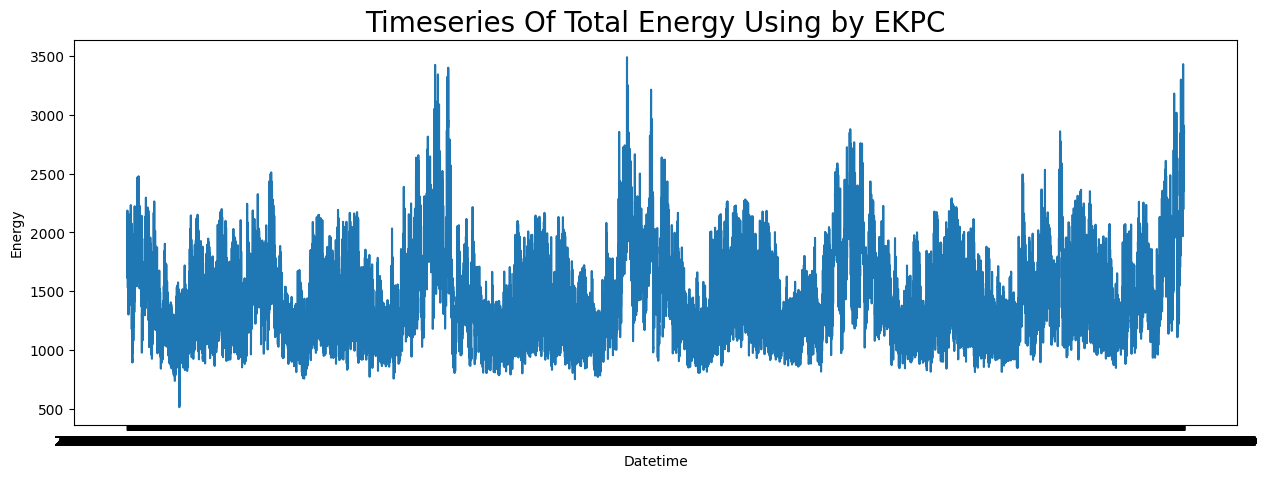

In [7]:
plt.figure(figsize=(15,5))
plt.plot(dates, EKPC_NW)
plt.title('Timeseries Of Total Energy Using by EKPC', fontsize=20)
plt.xlabel('Datetime')
plt.ylabel('Energy')
plt.show()

# Convert dtype object to datetime

In [8]:
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45334 entries, 0 to 45333
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Datetime  45334 non-null  datetime64[ns]
 1   EKPC_MW   45334 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 708.5 KB


In [9]:
EKPC_NW  = EKPC_NW.reshape(-1,1)
EKPC_NW


array([[1861.],
       [1835.],
       [1841.],
       ...,
       [2883.],
       [2880.],
       [2846.]])

# Normalization

In [10]:
scaler = MinMaxScaler()
EKPC_NW  = scaler.fit_transform(EKPC_NW)

# Membagi data training dan data testing


In [11]:
X_train, X_test, y_train, y_test = train_test_split(EKPC_NW, dates, test_size=0.2, shuffle=False)

In [12]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [13]:
train_set = windowed_dataset(X_train, window_size=60, batch_size=100, shuffle_buffer=1000)
test_set  = windowed_dataset(X_test, window_size=60, batch_size=32, shuffle_buffer=1000)

model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True, input_shape = [None, 1]),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [14]:
threshold_mae = (EKPC_NW.max() - EKPC_NW.min()) * 10/100
print("Batas maksimal nilai mae (10%) dari data adalah sebesar", threshold_mae)

Batas maksimal nilai mae (10%) dari data adalah sebesar 0.1


In [15]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if((logs.get('mae') < threshold_mae) and (logs.get('val_mae') < threshold_mae)):
      print("MAE < 10%")
      self.model.stop_training = True
callbacks = myCallback()

In [16]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])


hist = model.fit(train_set,
                    epochs=100,
                    validation_data=test_set,
                    verbose=2,
                    callbacks=[callbacks])

Epoch 1/100
363/363 - 52s - loss: 0.0310 - mae: 0.2107 - val_loss: 0.0183 - val_mae: 0.1467 - 52s/epoch - 145ms/step
Epoch 2/100
363/363 - 47s - loss: 0.0116 - mae: 0.1125 - val_loss: 0.0102 - val_mae: 0.1011 - 47s/epoch - 131ms/step
Epoch 3/100
MAE < 10%
363/363 - 46s - loss: 0.0084 - mae: 0.0996 - val_loss: 0.0087 - val_mae: 0.0969 - 46s/epoch - 128ms/step


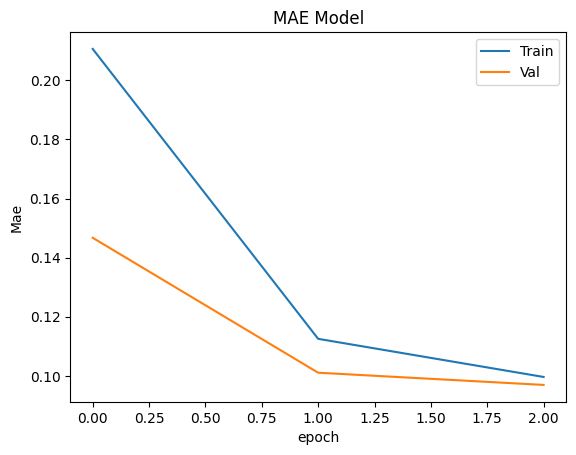

In [17]:
# Plot MAE

plt.plot(hist.history['mae'])
plt.plot(hist.history['val_mae'])
plt.title('MAE Model')
plt.ylabel('Mae')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'],  loc='upper right')
plt.show()

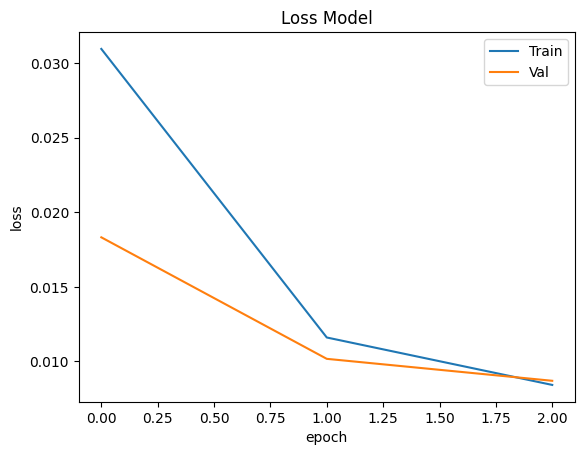

In [18]:
# Plot Loss

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()